In [112]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
import math
import matplotlib.mlab as mlab
from numpy import matrix
from numpy import linalg
from scipy import optimize
from scipy.optimize import minimize_scalar
from scipy.stats import norm
import statistics as stats
import scipy
from scipy.stats import weibull_min
from scipy.stats import multivariate_normal
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
from scipy.optimize import SR1
from scipy.optimize import Bounds
from scipy.optimize import linprog
import statistics
from scipy.stats import weibull_min
from sympy import solve
#from pynverse import inversefunc
from scipy.linalg import sqrtm
import sklearn
from sklearn.linear_model import LinearRegression

In [132]:
## Parameters
d=2
we=1.1
Id=np.identity(d,dtype='float')
B1= np.identity(d,dtype='float')
mean=np.zeros(d)
cov=B1
rho = 0.5
B1[0,1]=rho
B1[1,0]=rho
m=(np.linalg.inv(cov) -Id)

In [133]:
### Get density, Jacobian and CVaR
def weib(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)
def weicdf(x,a):
    return(np.exp(-x**a))
##Density function for Gaussian Copula
def gc(x,cov):
    y=prod(weib(x,1,we))
    g1=np.dot(np.dot( norm.isf(weicdf(x,we))  ,m), norm.isf(weicdf(x,we)))
    g=np.exp(-0.5*g1)
    z=abs(np.linalg.det(cov))**(-0.5)*g*y
    return z
def weiinv(x,a):
    return (-np.log(1-x))**(1/a)
##Jacobian for the Gaussian Copula
def JacTGC(Z1,Z2,r):
    jt=1+ (abs(Z1)*np.log(r))/(np.max(np.log(1+abs(Z1))) * (1+abs(Z1)))
    rexp=r**(sum(np.log(1+abs(Z1))/(np.log(1+np.max(abs(Z1))))))
    jac=gc(Z2,cov)/gc(Z1,cov)*np.prod(jt)*rexp/(np.max(jt))
    return jac
V1 = np.random.multivariate_normal(mean, cov, 10**6)
W1 = norm.cdf(V1)
X1=weiinv(W1,we)
def CVaR(b1, beta1):
    Y=np.inner(X1,b1)
    Ys=sorted(Y,reverse=True)
    Vbeta0 = Ys[int(10**6*beta1)]
    Cbeta0 = Vbeta0+ 1/(10**6*beta1) *np.maximum((Y - Vbeta0),0).sum()
    return(Cbeta0)

In [134]:
#Define functions and the true optimium: Implemtation 1
def VarISh(h,beta,Z1,u,theta):
    r = h*np.log(np.log (1/beta))
    A = np.zeros(len(Z1))
    Z2 = np.zeros((len(Z1),d))
    for i in range(len(Z1)-2):
        Z2[i,:]=Z1[i,:]*r**(np.log(1+(1*Z1[i,:]))/abs(np.max(np.log((1+1*Z1[i,:]))))) 
        A[i] = JacTGC(Z1[i,:],Z2[i,:],r)
    yloss= np.inner(Z2,theta)
    varIS = stats.variance( A*(np.sign(yloss  - u)+1)/2)
    return (varIS)
def besth(u,theta,beta,Z1):
    def optimcurrent(h):
        Z2 = np.zeros((len(Z1),d))
        r=h*np.log(np.log(1/beta))
        for i in range(len(Z1)-2):
            Z2[i,:]=Z1[i,:]*r**(np.log(1+(1*Z1[i,:]))/abs(np.max(np.log((1+1*Z1[i,:]))))) 
        return(VarISh(h,beta,Z1,u,theta))
    def equality_constraint(h):
        return (h -2)
#     con1 = {'type': 'ineq', 'fun': constraint1}
#     constraint=[constraint1]
    bnds = Bounds(2, 18)
    result=minimize_scalar(optimcurrent,h0, bounds=(2, 10), method='bounded', options = {'maxiter': 20})
    return(result.x)
def optsol(beta,Z1,h,x0): ## Get retrospective thetas
    lb= math.log(math.log(1/beta))
    ub=beta**(-0.5)
    #ele_lst=[]
    theta_values=[]
    for i in range(d):
        lb=append(lb, 0)
        ub=append(ub, 1)
    bounds=Bounds(lb,ub)
    r=h*np.log(np.log(1/beta))
    A=[]
    Z2 = np.zeros((len(Z1),d))
    for i in range(len(Z1)-2): #changes
        Z2[i,:]=Z1[i,:]*r**(np.log(1+abs(Z1[i,:])) / np.log(1+np.max(abs(Z1[i,:]))))    
        A=append(A,JacTGC(Z1[i,:],Z2[i,:],r))   ##Likelihood
    ##Define function
    def fxn(x):
        su=0
        for i in range(len(Z1)-2):
            su=su+((max(np.inner(x[1:],Z2[i,:])-x[0],0))*(beta**-1))*A[i]
        return(su/N +x[0])
    ##Define Constraints
    def equality_constraint(x):
        return (sum(x[1:]) -1)
    constraint1={'type':'eq','fun':equality_constraint}
    constraint=[constraint1]
    x0=[2,0.1,0.1,0.1,0.05,0.05,0.05,0.05,0.05,0.05,0.1, 0,0.6,0.4,0.2,0.8]
    x0=[3,0.4,0.2]
    result=minimize(fxn,x0,method='SLSQP',bounds=bounds,constraints=constraint,options = {'maxiter': 20})
    return(result.x)
def optvalue(beta,Z1,h,x0):
    lb= math.log(math.log(1/beta))
    ub=beta**(-0.5)
    #ele_lst=[]
    theta_values=[]
    for i in range(d):
        lb=append(lb, 0)
        ub=append(ub, 1)
    bounds=Bounds(lb,ub)
    r=h*np.log(np.log(1/beta))
    A=[]
    Z2 = np.zeros((len(Z1),d))
    for i in range(len(Z1)-2): #changes
        Z2[i,:]=Z1[i,:]*r**(np.log(1+abs(Z1[i,:])) / np.log(1+np.max(abs(Z1[i,:]))))    
        A=append(A,JacTGC(Z1[i,:],Z2[i,:],r))   ##Likelihood
    ##Define function
    def fxn(x):
        su=0
        for i in range(len(Z1)-2):
            su=su+((max(np.inner(x[1:],Z2[i,:])-x[0],0))*(beta**-1))*A[i]
        return(su/N +x[0])
    ##Define Constraints
    def equality_constraint(x):
        return (sum(x[1:]) -1)
    constraint1={'type':'eq','fun':equality_constraint}
    constraint=[constraint1]
    x0=[2,0.1,0.1,0.1,0.05,0.05,0.05,0.05,0.05,0.05,0.1, 0,0.6,0.4,0.2,0.8]
    x0=[3,0.4,0.2]
    result=minimize(fxn,x0,method='SLSQP',bounds=bounds,constraints=constraint,options = {'maxiter': 20})
    return(result.fun)

In [137]:
N=500
beta=0.01
## Generate random variables
V = np.random.multivariate_normal(mean, cov, N)
W = norm.cdf(V)
X=weiinv(W,we)
Z1=X
h0=2
th0=[8,0.2,0.8]
th1=optsol(beta,Z1,h0,th0)
h1=besth(th1[0],th1[1:],beta,Z1)
th2=optsol(beta,Z1,h1,th1)
h2=besth(th2[0],th2[1:],beta,Z1)
th3=optsol(beta,Z1,h2,th2)
h3=besth(th3[0],th3[1:],beta,Z1)
th4=optsol(beta,Z1,h3,th3)
h4=besth(th3[0],th3[1:],beta,Z1)
print("h-sequence", h1,h2,h3,h4)
print("var-sequence", th0[0],th1[0],th2[0],th3[0], th4[0])
print("weights-sequence", th0[1],th1[1],th2[1],th3[1], th4[1])
## Compute MC solution

h-sequence 3.521734517668154 3.31809059186787 3.2996511657409417 3.2996511657409417
var-sequence 8 3.5848744658777267 3.3719232295808137 3.3559522067605183 3.3396355949258907
weights-sequence 0.2 0.460010810393243 0.5062172541152925 0.5114630681438448 0.5117700950394095


In [136]:
def fxn(x):
    s_inner = np.maximum(np.inner(x[1:],X1)-x[0],0)
    s= sum(s_inner)/beta
    return(x[0]+s/10**6)
def equality_constraint(x):
        return (sum(x[1:]) -1)
constraint1={'type':'eq','fun':equality_constraint}
constraint=[constraint1]
bounds = Bounds(np.zeros(d+1),np.inf*np.ones(d+1))
x0_full=[9,0.1,0.1,1,1,1,1,2.4,1,4,5,2,5,1,2,1]
x0=x0_full[0:d+1]
result=minimize(fxn,x0,method='SLSQP',constraints=constraint, bounds=bounds)
theta_opt=result.x
theta_opt

array([3.46732351, 0.49755207, 0.50244793])

In [125]:
## Generate Conditional Samples
### Generate conditional samples of X in the feasible region
Xcond0 = X1[np.inner(th0[1:],X1)>2]
Xcond1=X1[np.inner(th1[1:],X1)>th1[0]]
Xcond2=X1[np.inner(th2[1:],X1)>th2[0]] ## These are conditional samples
### Generate transformed samples in the feasibile regions
def Th(x):
    z = x*h**((1+np.log(abs(x)))/(1+np.max(abs(x))))
    return(z)
h=h0
Xtransf0 = np.apply_along_axis(Th, 1,X1)
h=h1
Xtransf1 = np.apply_along_axis(Th, 1,X1)
h=h2
Xtransf2 = np.apply_along_axis(Th, 1,X1)
XcondT0 = Xtransf0[np.inner(th0[1:],Xtransf0)>2]
XcondT1 = Xtransf1[np.inner(th1[1:],Xtransf1)>th1[0]]
XcondT2 = Xtransf2[np.inner(th2[1:],Xtransf2)>th2[0]]

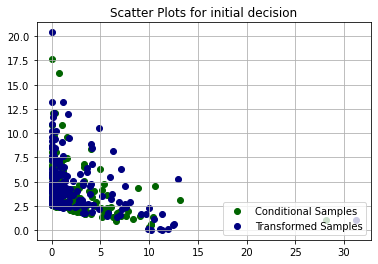

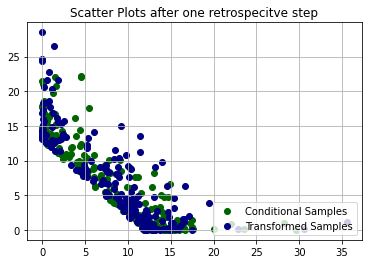

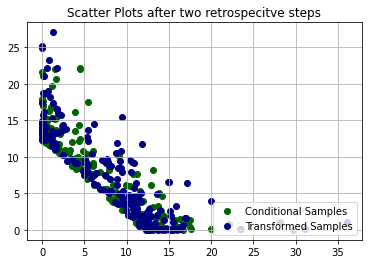

In [126]:
## Generate Plots
plt.scatter(Xcond0[0:200,0], Xcond0[0:200,1], alpha=1, color='darkgreen', marker = "o")
plt.scatter(XcondT0[0:200,0], XcondT0[0:200,1], alpha=1, color='navy', marker = "o")
plt.grid(True)
plt.title("Scatter Plots for initial decision")
plt.legend(["Conditional Samples", "Transformed Samples"], loc ="lower right") 
plt.savefig("Scatter_plot_initial_decision_rho2.pdf") 
plt.show()
plt.scatter(Xcond1[0:200,0], Xcond1[0:200,1], alpha=1, color='darkgreen', marker = "o")
plt.scatter(XcondT1[0:200,0], XcondT1[0:200,1], alpha=1, color='navy', marker = "o")
plt.grid(True)
plt.title("Scatter Plots after one retrospecitve step")
plt.legend(["Conditional Samples", "Transformed Samples"], loc ="lower right") 
plt.savefig("Scatter_plot_firststage_decision_rho2.pdf") 
plt.show()
plt.scatter(Xcond2[0:200,0], Xcond2[0:200,1], alpha=1, color='darkgreen', marker = "o")
plt.scatter(XcondT2[0:200,0], XcondT2[0:200,1], alpha=1, color='navy', marker = "o")
plt.grid(True)
plt.title("Scatter Plots after two retrospecitve steps")
plt.legend(["Conditional Samples", "Transformed Samples"], loc ="lower right") 
plt.savefig("Scatter_plot_secondstage_decision_rho2.pdf") 
plt.show()

In [138]:
## Generate histograms of likelihood for the retrospective steps
### Step 0: Compute transformed samples
LR_init=[]
h=h0
TXcond0=np.apply_along_axis(Th, 1,Xcond0)
for i in range(len(TXcond0)):
    LR_step1=append(LR_init,JacTGC(Xcond0[i,:],TXcond0[i,:],h)) 
### Step 1: Compute transformed samples
LR_step1=[]
h=h1
TXcond1=np.apply_along_axis(Th, 1,Xcond1)
for i in range(len(TXcond1)):
    LR_step1=append(LR_step1,JacTGC(Xcond1[i,:],TXcond1[i,:],h)) 
### Step 2: Compute transformed samples
LR_step2=[]
h=h2
TXcond2=np.apply_along_axis(Th, 1,Xcond2)
for i in range(len(TXcond2)):
    LR_step2=append(LR_step2,JacTGC(Xcond2[i,:],TXcond2[i,:],h)) 

KeyboardInterrupt: 

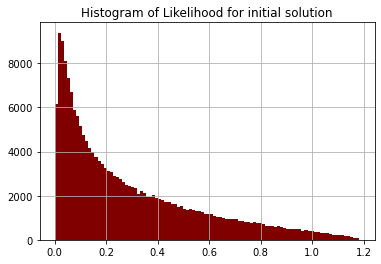

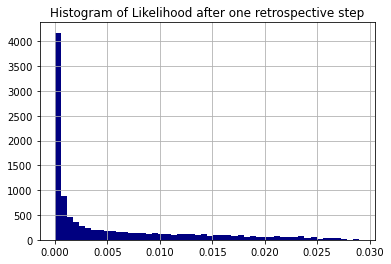

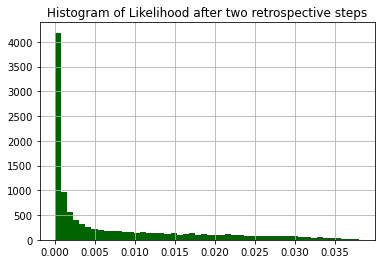

In [152]:
### Generate Plots
plt.hist(LR_init, bins=100, color = 'maroon')
plt.grid(True)
plt.title("Histogram of Likelihood for initial solution")
plt.savefig("Histogram_Likelihood_init.pdf")
plt.show()
plt.hist(LR_step1, bins=50, color = 'navy')
plt.grid(True)
plt.title("Histogram of Likelihood after one retrospective step")
plt.savefig("Histogram_Likelihood_firststep.pdf")
plt.show()
plt.savefig("Scatter_plot_secondstage_decision_rho2.pdf") 
plt.hist(LR_step2, bins=50, color = 'darkgreen')
plt.grid(True)
plt.title("Histogram of Likelihood after two retrospective steps")
plt.savefig("Histogram_Likelihood_secondstep.pdf")
plt.show()